# Vision Transformer (ViT)
ViT paper: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
https://arxiv.org/abs/2010.11929

In [1]:
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision not available.")

torch version: 2.0.1
torchvision version: 0.15.2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.") #pip install -q torchinfo

In [5]:
import os
from pathlib import Path
print("Current folder:", os.getcwd())

Current folder: /home/010796032/MyRepo/DeepDataMiningLearning/DeepDataMiningLearning


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# Setup Dirs
image_path = Path("/data/cmpe249-fa23/ImageClassData/flower_photos/")
train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [8]:
NUM_WORKERS = os.cpu_count()
def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [9]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fb4dd443e20>,
 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])

In [10]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

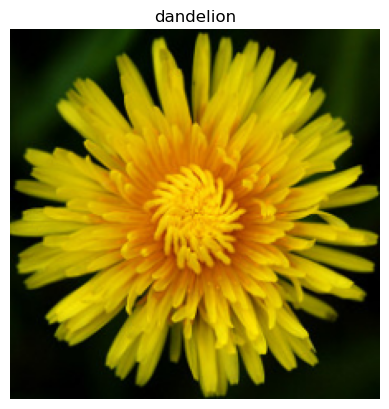

In [11]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png" width=900 alt="figure 1 from the original vision transformer paper"/>

*Figure 1 from the ViT Paper showcasing the different inputs, outputs, layers and blocks that create the architecture. Our goal will be to replicate each of these using PyTorch code.* 

The ViT architecture is comprised of several stages:
* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and add a position number what order the patch comes in.
* **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an **embedding**, the benefit of using an embedding rather than just the image values is that an embedding is a *learnable* representation (typically in the form of a vector) of the image that can improve with training.
* **Norm** - This is short for "[Layer Normalization](https://paperswithcode.com/method/layer-normalization)" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer [`torch.nn.LayerNorm()`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
* **Multi-Head Attention** - This is a [Multi-Headed Self-Attention layer](https://paperswithcode.com/method/multi-head-attention) or "MSA" for short. You can create an MSA layer via the PyTorch layer [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
* **MLP (or [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a `forward()` method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two [`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers with a [`torch.nn.GELU()`](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) non-linearity activation in between them (section 3.1) and a [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layer after each (Appendex B.1). 
* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
* **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.


We'll begin by following the opening paragraph of section 3.1 of the ViT paper (bold mine):

> The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the **patch embeddings**.

And size we're dealing with image shapes, let's keep in mind the line from Table 3 of the ViT paper: 

> Training resolution is **224**.

Let's break down the text above.

* $D$ is the size of the **patch embeddings**, different values for $D$ for various sized ViT models can be found in Table 1.
* The image starts as 2D with size ${H \times W \times C}$.
    * $(H, W)$ is the resolution of the original image (height, width).
    * $C$ is the number of channels.
* The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
    * $(P, P)$ is the resolution of each image patch (**patch size**).
    * $N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.

In [12]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")


Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

In [13]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


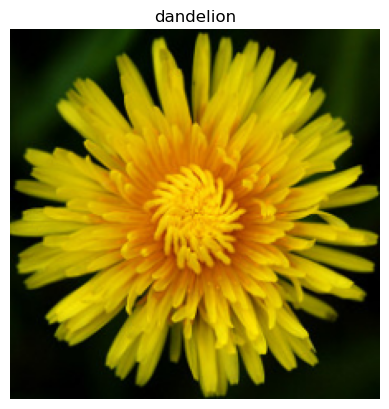

In [14]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

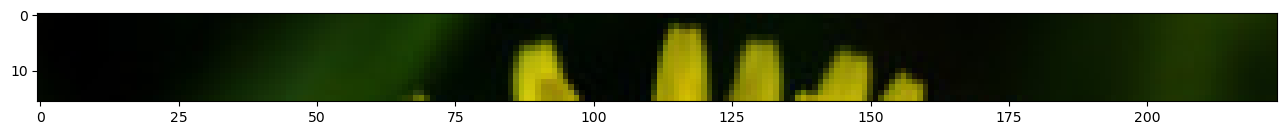

In [15]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels) 
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


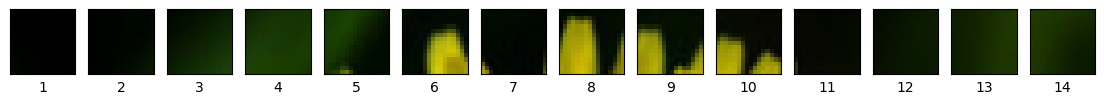

In [16]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1, 
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


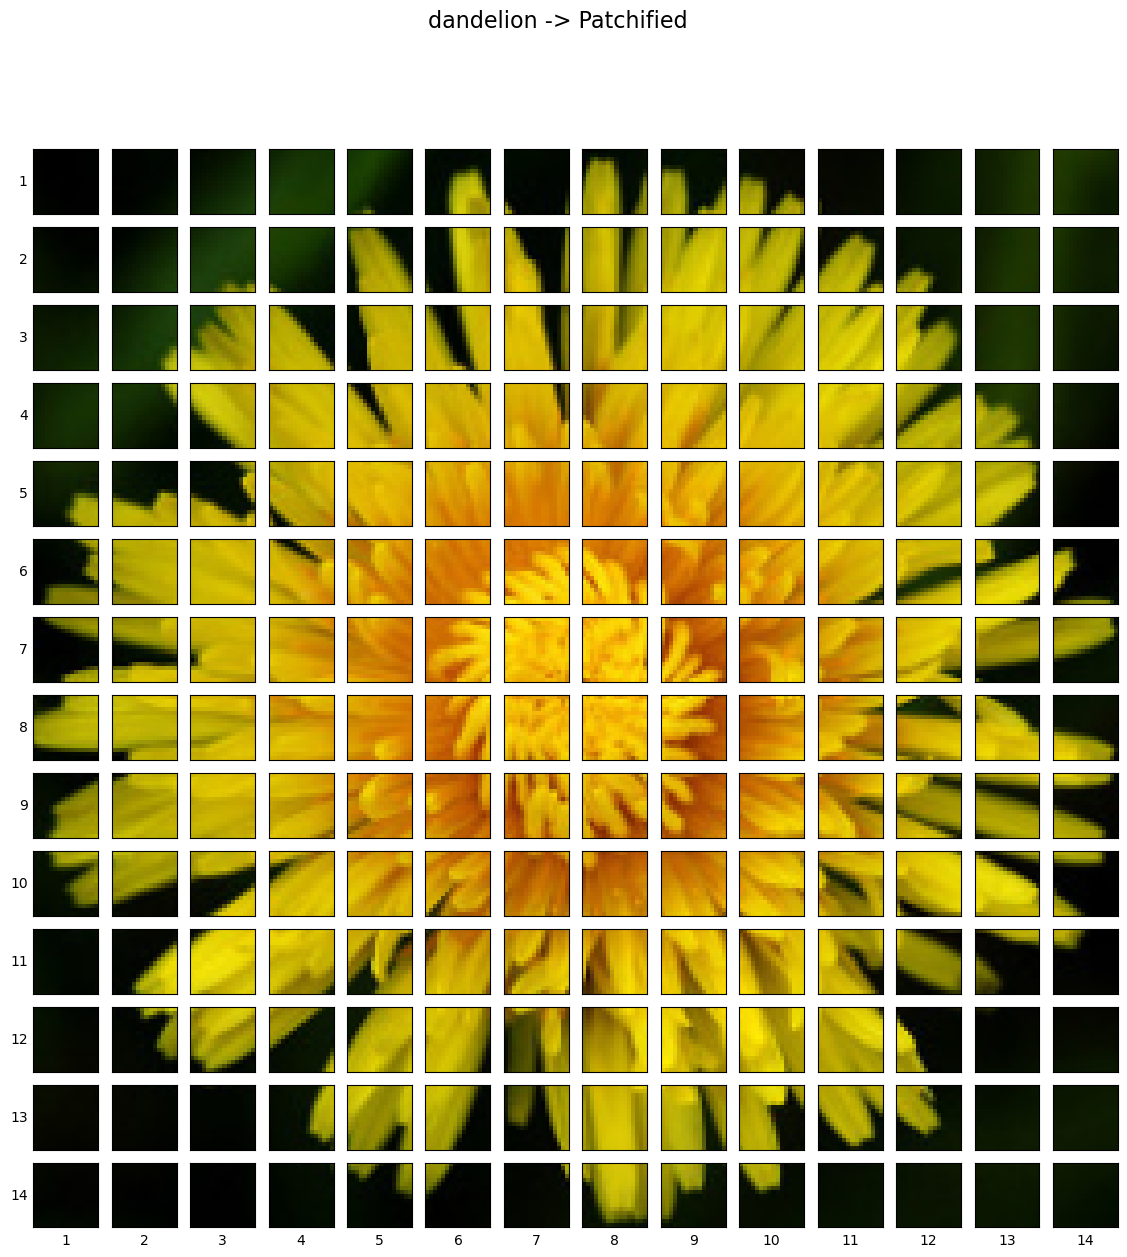

In [17]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height 
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels
        
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

Patch Embedding layers

the authors of the ViT paper mention in section 3.1 that the patch embedding is achievable with a convolutional neural network (CNN):  

> **Hybrid Architecture.** As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding projection $\mathbf{E}$ (Eq. 1) is applied to patches extracted from a **CNN feature map**. As a special case, the patches can have spatial size $1 \times 1$, which means that the **input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension**. The classification input embedding and position embeddings are added as described above.

The "**feature map**" they're refering to are the weights/activations produced by a convolutional layer passing over a given image.

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-patch-embedding-animation.gif" width=900 alt="example of creating a patch embedding by passing a convolutional layer over a single image"/>

*By setting the `kernel_size` and `stride` parameters of a [`torch.nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) layer equal to the `patch_size`, we can effectively get a layer that splits our image into patches and creates a learnable embedding (referred to as a "Linear Projection" in the ViT paper) of each patch.* 


our ideal input and output shapes for the patch embedding layer?

* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a 1D sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

Or for an image size of 224 and patch size of 16:

* **Input (2D image):** (224, 224, 3) -> (height, width, color channels)
* **Output (flattened 2D patches):** (196, 768) -> (number of patches, embedding dimension)

We can recreate these with:
* [`torch.nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) for turning our image into patches of CNN feature maps.
* [`torch.nn.Flatten()`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) for flattening the spatial dimensions of the feature map.

Let's start with the `torch.nn.Conv2d()` layer.

We can replicate the creation of patches by setting the `kernel_size` and `stride` equal to `patch_size`.

This means each convolutional kernel will be of size `(patch_size x patch_size)` or if `patch_size=16`, `(16 x 16)` (the equivalent of one whole patch).

And each step or `stride` of the convolutional kernel will be `patch_size` pixels long or `16` pixels long (equivalent of stepping to the next patch).

We'll set `in_channels=3` for the number of color channels in our image and we'll set `out_channels=768`, the same as the $D$ value in Table 1 for ViT-Base (this is the embedding dimension, each image will be embedded into a learnable vector of size 768).

In [18]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

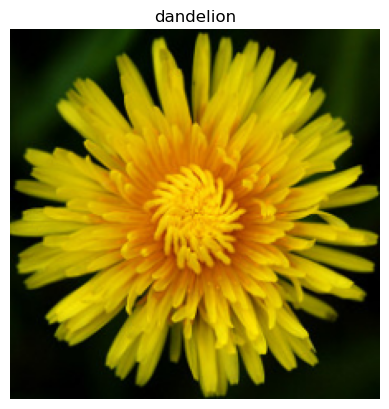

In [19]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [20]:
# Pass the image through the convolutional layer 
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Passing our image through the convolutional layer turns it into a series of 768 (this is the embedding size or $D$) feature/activation maps.

So its output shape can be read as:
    
```python
torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Let's visualize five random feature maps and see what they look like.

Showing random convolutional feature maps from indexes: [668, 673, 343, 51, 509]


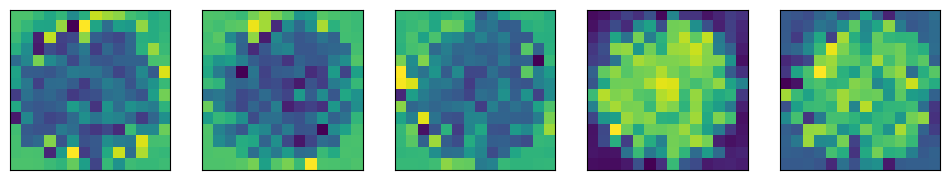

In [21]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

## Flattening the patch embedding with torch.nn.Flatten()

We've turned our image into patch embeddings but they're still in 2D format.

How do we get them into the desired output shape of the patch embedding layer of the ViT model?

* **Desired output (1D sequence of flattened 2D patches):** (196, 768) -> (number of patches, embedding dimension) -> ${N \times\left(P^{2} \cdot C\right)}$

In [22]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


Well we've got the 768 part ( $(P^{2} \cdot C)$ ) but we still need the number of patches ($N$).

Reading back through section 3.1 of the ViT paper it says (bold mine):

> As a special case, the patches can have spatial size $1 \times 1$, which means that the **input sequence is obtained by simply *flattening* the spatial dimensions of the feature map and projecting to the Transformer dimension**.

In [23]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

In [24]:

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


* **Desired output (flattened 2D patches):** (196, 768) -> ${N \times\left(P^{2} \cdot C\right)}$
* **Current shape:** (1, 768, 196)

In [25]:
# Get flattened image patch embeddings in right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


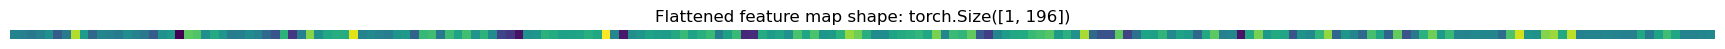

In [26]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

We can create a class called PatchEmbedding by subclassing `nn.Module` and creating a small PyTorch "model" to do all of the steps above.

Specifically we'll:
1. Create a class called `PatchEmbedding` which subclasses `nn.Module` (so it can be used a PyTorch layer).
2. Initialize the class with the parameters `in_channels=3`, `patch_size=16` (for ViT-Base) and `embedding_dim=768` (this is $D$ for ViT-Base from Table 1).
3. Create a layer to turn an image into patches using `nn.Conv2d()` (just like in 4.3 above).
4. Create a layer to flatten the patch feature maps into a single dimension (just like in 4.4 above). 
5. Define a `forward()` method to take an input and pass it through the layers created in 3 and 4.
6. Make sure the output shape reflects the required output shape of the ViT architecture (${N \times\left(P^{2} \cdot C\right)}$).

In [27]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [29]:
#try one image
# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


The output shape matches the ideal input and output shapes we'd like to see from the patch embedding layer:

* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a 1D sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

Where:
* $(H, W)$ is the resolution of the original image.
* $C$ is the number of channels.
* $(P, P)$ is the resolution of each image patch (**patch size**).
* $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer.

In [30]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(), 
        input_size=random_input_image, # try swapping this for "random_input_image_error" 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

## class token embedding


> Similar to BERT's `[ class ]` token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4). 

> **Note:** [BERT](https://arxiv.org/abs/1810.04805) (Bidirectional Encoder Representations from Transformers) is one of the original machine learning research papers to use the Transformer architecture to achieve outstanding results on natural language processing (NLP) tasks and is where the idea of having a `[ class ]` token at the start of a sequence originated, class being a description for the "classification" class the sequence belonged to.


In [31]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")


tensor([[[ 0.0347, -0.0037, -0.0240,  ..., -0.0022, -0.0324,  0.0308],
         [ 0.0422,  0.0013, -0.0221,  ...,  0.0060, -0.0311,  0.0267],
         [ 0.0638,  0.0217, -0.0116,  ..., -0.0042, -0.0521,  0.0447],
         ...,
         [ 0.0322, -0.0050, -0.0141,  ..., -0.0081, -0.0575,  0.0547],
         [ 0.0245, -0.0085, -0.0125,  ..., -0.0039, -0.0703,  0.0587],
         [ 0.0238, -0.0160, -0.0143,  ..., -0.0063, -0.0704,  0.0551]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


To "prepend a learnable embedding to the sequence of embedded patches" we need to create a learnable embedding in the shape of the `embedding_dimension` ($D$) and then add it to the `number_of_patches` dimension. 

Or in pseudocode:

```python
patch_embedding = [image_patch_1, image_patch_2, image_patch_3...]
class_token = learnable_embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
```

Notice the concatenation (`torch.cat()`) happens on `dim=1` (the `number_of_patches` dimension).

In [32]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


The number_of_tokens dimension of class_token is 1 since we only want to prepend one class token value to the start of the patch embedding sequence.

Now we've got the class token embedding, let's prepend it to our sequence of image patches, patch_embedded_image.

We can do so using torch.cat() and set dim=1 (so class_token's number_of_tokens dimension is preprended to patch_embedded_image's number_of_patches dimension).

In [33]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.0347, -0.0037, -0.0240,  ..., -0.0022, -0.0324,  0.0308],
         [ 0.0422,  0.0013, -0.0221,  ...,  0.0060, -0.0311,  0.0267],
         ...,
         [ 0.0322, -0.0050, -0.0141,  ..., -0.0081, -0.0575,  0.0547],
         [ 0.0245, -0.0085, -0.0125,  ..., -0.0039, -0.0703,  0.0587],
         [ 0.0238, -0.0160, -0.0143,  ..., -0.0063, -0.0704,  0.0551]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-prepending-the-learnable-class-token.png" width=900 alt="going from a sequence of patch embeddings, creating a learnable class token and then prepending it to the patch embeddings"/>

*Reviewing what we've done to create the learnable class token, we start with a sequence of image patch embeddings created by `PatchEmbedding()` on single image, we then created a learnable class token with one value for each of the embedding dimensions and then prepended it to the original sequence of patch embeddings. **Note:** Using `torch.ones()` to create the learnable class token is mostly for demonstration purposes only, in practice, you'd likely create it with `torch.randn()`.* 

## Creating the position embedding


> Position embeddings are added to the patch embeddings to retain positional information. We use **standard learnable 1D position embeddings**, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

By "retain positional information" the authors mean they want the architecture to know what "order" the patches come in. As in, patch two comes after patch one and patch three comes after patch two and on and on.

This positional information can be important when considering what's in an image (without positional information an a flattened sequence could be seen as having no order and thus no patch relates to any other patch). 

In [34]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.0347, -0.0037, -0.0240,  ..., -0.0022, -0.0324,  0.0308],
          [ 0.0422,  0.0013, -0.0221,  ...,  0.0060, -0.0311,  0.0267],
          ...,
          [ 0.0322, -0.0050, -0.0141,  ..., -0.0081, -0.0575,  0.0547],
          [ 0.0245, -0.0085, -0.0125,  ..., -0.0039, -0.0703,  0.0587],
          [ 0.0238, -0.0160, -0.0143,  ..., -0.0063, -0.0704,  0.0551]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

Equation 1 states that the position embeddings ($\mathbf{E}_{\text {pos }}$) should have the shape $(N + 1) \times D$:

$$\mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}$$

Where: 
* $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer (number of patches).
* $D$ is the size of the **patch embeddings**, different values for $D$ can be found in Table 1 (embedding dimension).

Luckily we've got both of these values already.

So let's make a learnable 1D embedding with `torch.ones()` to create $\mathbf{E}_{\text {pos }}$. 

In [35]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1, 
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")


tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


> **Note:** Only creating the position embedding as `torch.ones()` for demonstration purposes, in reality, you'd likely create the position embedding with `torch.randn()` (start with a random number and improve via gradient descent). 

Position embeddings created!

Let's add them to our sequence of patch embeddings with a prepended class token.

In [36]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")


tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.0347, 0.9963, 0.9760,  ..., 0.9978, 0.9676, 1.0308],
         [1.0422, 1.0013, 0.9779,  ..., 1.0060, 0.9689, 1.0267],
         ...,
         [1.0322, 0.9950, 0.9859,  ..., 0.9919, 0.9425, 1.0547],
         [1.0245, 0.9915, 0.9875,  ..., 0.9961, 0.9297, 1.0587],
         [1.0238, 0.9840, 0.9857,  ..., 0.9937, 0.9296, 1.0551]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Notice how the values of each of the elements in the embedding tensor increases by 1 (this is because of the position embeddings being created with `torch.ones()`). 

> **Note:** We could put both the class token embedding and position embedding into their own layer if we wanted to. But we'll see later on in section 8 how they can be incorporated into the overall ViT architecture's `forward()` method.

*The workflow we've used for adding the position embeddings to the sequence of patch embeddings and class token. **Note:** `torch.ones()` only used to create embeddings for illustration purposes, in practice, you'd likely use `torch.randn()` to start with a random number.*

## Putting it all together: from image to embedding

equation 1 from section 3.1 of the ViT paper:

$$
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$

Put everything together in a single code cell and go from input image ($\mathbf{x}$) to output embedding ($\mathbf{z}_0$).


In [37]:

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Multi-Head Attention (MSA)
equation 2 states:

$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

This indicates a Multi-Head Attention (MSA) layer wrapped in a LayerNorm (LN) layer with a residual connection (the input to the layer gets added to the output of the layer).

Many layers are already implemented in PyTorch.

* **Multi-Head Self Attention (MSA)** - [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html). 
* **Norm (LN or LayerNorm)** - [`torch.nn.LayerNorm()`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
* **Residual connection** - add the input to output

The triple embedding input to the MSA layer.

This is known as **query, key, value** input or **qkv** for short which is fundamental to the self-attention mechanism.

In our case, the triple embedding input will be three versions of the output of the Norm layer, one for query, key and value.

We can implement the MSA layer in PyTorch with `torch.nn.MultiheadAttention()` with the parameters:
* `embed_dim` - the embedding dimension from Table 1 (Hidden size $D$).
* `num_heads` - how many attention heads to use (this is where the term "multihead" comes from), this value is also in Table 1 (Heads).
* `dropout`. 
* `batch_first` - does our batch dimension come first? 

In [38]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

Our `MultiheadSelfAttentionBlock` doesn't include a skip or residual connection ("$+\mathbf{z}_{\ell-1}$" in equation 2), we'll include this when we create the entire Transformer Encoder later 

In [39]:
# try it out by create an instance of our `MultiheadSelfAttentionBlock` and passing through the `patch_and_position_embedding` variable we created
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1 
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [40]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [41]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1 
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


## Create the Transformer Encoder

Stack together our `MultiheadSelfAttentionBlock` (equation 2) and `MLPBlock` (equation 3) and create the Transformer Encoder of the ViT architecture.

in pseudocode:

`x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...`


In [42]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method  
    def forward(self, x):
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x

Let's get a torchinfo.summary() of passing an input of shape (1, 197, 768) -> (batch_size, num_patches, embedding_dimension) to our Transformer Encoder block.

In [43]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

PyTorch now has in-built [Transformer layers as part of `torch.nn`](https://pytorch.org/docs/stable/nn.html#transformer-layers). 

For example, we can recreate the `TransformerEncoderBlock` we just created using [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) and setting the same hyperparameters as above.

In [44]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [46]:
# # Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [47]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x       

In [48]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}") 
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


the first dimension gets expanded to the batch size and the other dimensions stay the same (because they're inferred by the "`-1`" dimensions in `.expand(batch_size, -1, -1)`).


In [49]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.1216, -0.1519,  0.9368,  1.7208,  0.3384]],
       grad_fn=<AddmmBackward0>)

In [50]:
# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 5]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

The number is very close to PyTorch's pretrained ViT-Base with patch size 16 at [`torch.vision.models.vit_b_16()`](https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16) with 86,567,656 total parameters (though this number of parameters is for the 1000 classes in ImageNet).


## Training

In [51]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

In [52]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

/home/010796032/miniconda3/envs/mycondapy310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [53]:
# Train the model and save the training results to a dictionary
results = train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

 10%|████████▍                                                                           | 1/10 [01:17<11:41, 77.99s/it]

Epoch: 1 | train_loss: 2.0242 | train_acc: 0.2123 | test_loss: 1.6610 | test_acc: 0.1673


 20%|████████████████▊                                                                   | 2/10 [02:36<10:24, 78.05s/it]

Epoch: 2 | train_loss: 1.6388 | train_acc: 0.2179 | test_loss: 1.6164 | test_acc: 0.1857


 30%|█████████████████████████▏                                                          | 3/10 [03:54<09:06, 78.00s/it]

Epoch: 3 | train_loss: 1.6116 | train_acc: 0.2393 | test_loss: 1.6153 | test_acc: 0.2353


 40%|█████████████████████████████████▌                                                  | 4/10 [05:11<07:47, 77.98s/it]

Epoch: 4 | train_loss: 1.6107 | train_acc: 0.2172 | test_loss: 1.6052 | test_acc: 0.2426


 50%|██████████████████████████████████████████                                          | 5/10 [06:29<06:29, 77.97s/it]

Epoch: 5 | train_loss: 1.6030 | train_acc: 0.2447 | test_loss: 1.6033 | test_acc: 0.2426


 60%|██████████████████████████████████████████████████▍                                 | 6/10 [07:47<05:11, 77.86s/it]

Epoch: 6 | train_loss: 1.6038 | train_acc: 0.2448 | test_loss: 1.5991 | test_acc: 0.2426


 70%|██████████████████████████████████████████████████████████▊                         | 7/10 [09:05<03:53, 77.93s/it]

Epoch: 7 | train_loss: 1.6028 | train_acc: 0.2446 | test_loss: 1.6015 | test_acc: 0.2426


 80%|███████████████████████████████████████████████████████████████████▏                | 8/10 [10:23<02:35, 77.90s/it]

Epoch: 8 | train_loss: 1.6036 | train_acc: 0.2447 | test_loss: 1.6022 | test_acc: 0.2426


 90%|███████████████████████████████████████████████████████████████████████████▌        | 9/10 [11:42<01:18, 78.11s/it]

Epoch: 9 | train_loss: 1.6039 | train_acc: 0.2446 | test_loss: 1.6021 | test_acc: 0.2426


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [12:59<00:00, 78.00s/it]

Epoch: 10 | train_loss: 1.6037 | train_acc: 0.2449 | test_loss: 1.6025 | test_acc: 0.2426


In [55]:
#https://pytorch.org/tutorials/beginner/saving_loading_models.html
filename=os.path.join('../data', 'myvitcheckpoint.pth.tar')
torch.save(vit.state_dict(), filename)

In [56]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

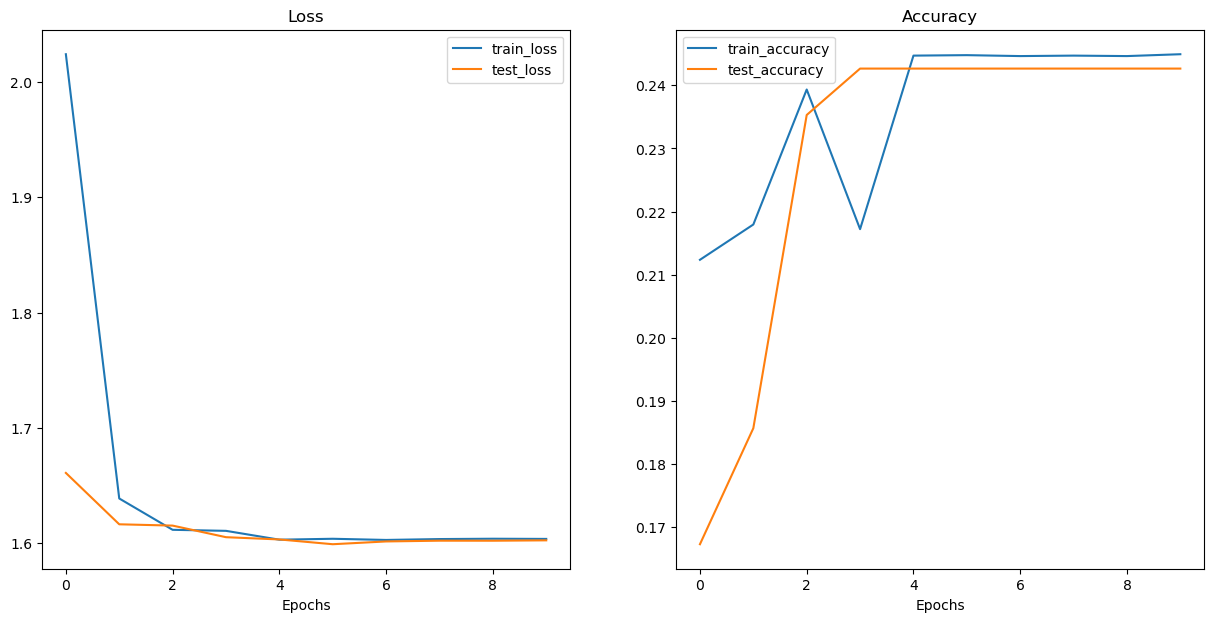

In [57]:
# Plot our ViT model's loss curves
plot_loss_curves(results)